# Develop code for extracting the sub-pixel information from the correlation maps
---

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
from lib.FT_modelling import *
from lib.formatter import * 
from lib.photometry import *

In [4]:
pupil = pupil_from_fits("pupil.fits")

In [5]:
# Define simulation parameters
aperture = 0.018 # 18mm
m2_obsc = 0 # m
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 512 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**10 # 1024
x = 0 # On-axis star (pixel units)
y = 0 # On-axis star (pixel units)

---
### Testing the single PSF autocorrelation

> First we want to generate this data on a high resolution grid, and try fitting a gaussian to the resutling correlation peak. From this correlation peak we will run a model fitting algorithm to find the parameters of tjhe gaussian distribution that gives the best fit. 

> From these parameters we will generate a series of arrays with these gaussian distributions and take a subtraction of these from our correlation map and find the result with the lowest error.

> We could possibly use a form of 2D binary search to decrease the computational complexity of the fit since we will need to perform this sub-pixel fix on each iteration of clean

In [6]:
tf_size = 2**13
pix_size = 0.1*1.12e-6
npix = 1024

In [7]:
np.ceil(np.log2(4*npix))

12.0

In [8]:
%%time
# Create a model m, PSF on a grid twice the size of the data image
m = FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, tf_size, x, y)

CPU times: user 8.27 s, sys: 3.79 s, total: 12.1 s
Wall time: 13.4 s


In [15]:
%%time
auto_corr = correlate(m, m)
auto_corr = auto_corr/np.max(auto_corr)

CPU times: user 151 ms, sys: 47.9 ms, total: 199 ms
Wall time: 204 ms


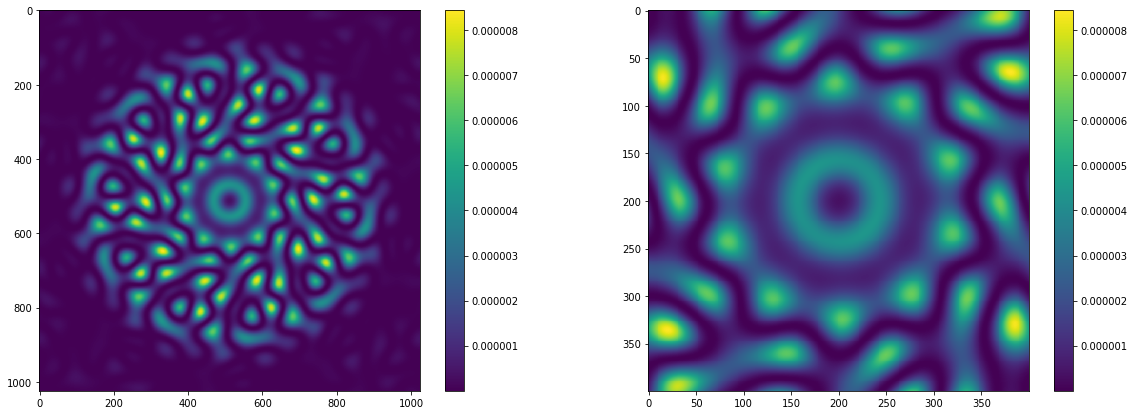

In [16]:
s = 200
c = npix//2
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(m)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(m[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

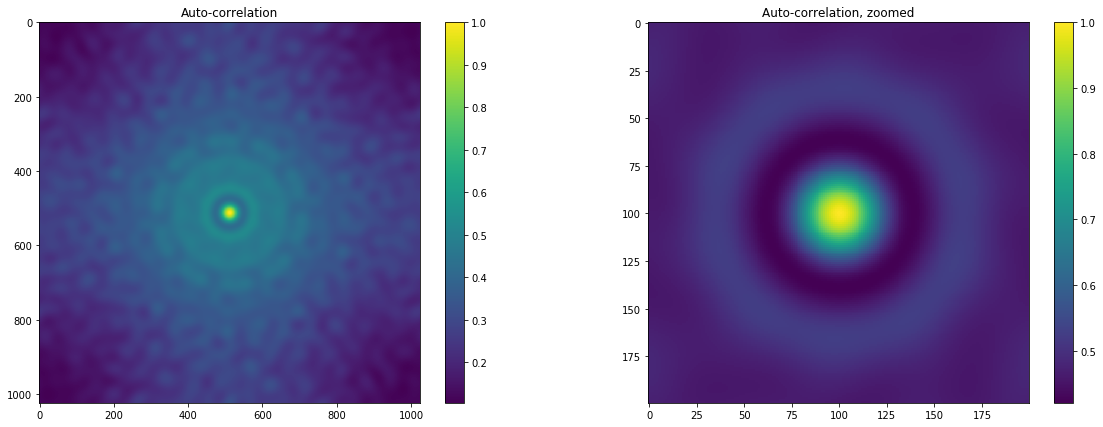

In [17]:
plt.figure(figsize=(20,7))
s2 = 100

plt.subplot(1,2,1)
plt.title("Auto-correlation")
plt.imshow(auto_corr)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Auto-correlation, zoomed")
plt.imshow(auto_corr[c-s2:c+s2, c-s2:c+s2])
plt.colorbar()

plt.savefig("images/auto_correlation_highres")
plt.show()

In [20]:
# Cut non central region
dim = 2*s2
xs = np.linspace(0, dim, num=dim, endpoint=False) - (dim/2)
X, Y = np.meshgrid(xs, xs)
R = np.hypot(X, Y)

rmax = 38 # Experimetnally determined
central = auto_corr[c-s2:c+s2, c-s2:c+s2]
data = central-np.min(central)
data[R > rmax] = 0
data = data/np.max(data)

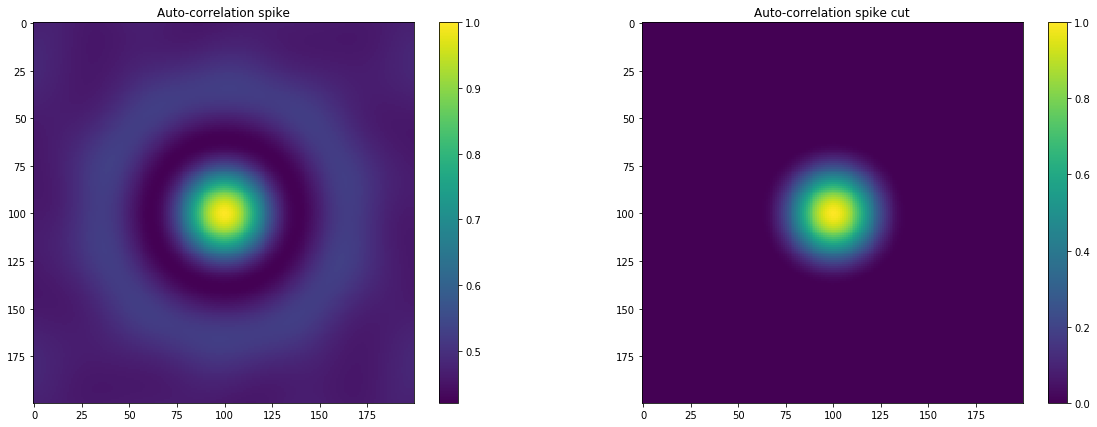

In [21]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title("Auto-correlation spike")
plt.imshow(auto_corr[c-s2:c+s2, c-s2:c+s2])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Auto-correlation spike cut")
plt.imshow(data)
plt.colorbar()

plt.savefig("images/auto_correlation_sub_cut")
plt.show()

Now we want to fit this with a Gaussian distribution

---


In [57]:
# Initilisation parameters

A0 = 1
sig0 = 10
p0 = 1
x0 = 100
y0 = 100

In [56]:
def fit_gaussian(inputs):
    model = gaussian(inputs)
    diff = np.sum((data-model)**2)
    return diff

def gaussian(inputs):
    A, sig, p, x0, y0 = inputs
    
    xs = np.linspace(0, dim, num=dim, endpoint=False)
    X, Y = np.meshgrid(xs, xs)
    
    xcomp = ((x0-X)**2)/(2*sig**2)
    ycomp = ((y0-Y)**2)/(2*sig**2)
    expo = (xcomp + ycomp)**p
    y = A*np.exp(-expo)
    
    return y

In [64]:
start1 = [A, sig, p, x0, y0]

In [65]:
res1 = minimize(fit_gaussian, start1)#, bounds=bounds)
gauss1 = gaussian(res1["x"])
diff1 = data - gauss1
A1, sig1, p1, x1, y1 = res1["x"]

print("Error out: {}".format(res1["fun"]))
print("Iterations: {}".format(res1["nit"]))
print("Amplitude: {}".format(A1))
print("Sigma: {}".format(sig1))
print("Power: {}".format(p1))
print("Position: ({}, {})".format(x1, y1))

Error out: 0.5539175464144565
Iterations: 4
Amplitude: 0.9560733115458723
Sigma: 15.163002025409607
Power: 1.2663959350937155
Position: (99.99994133298661, 99.99995464522922)


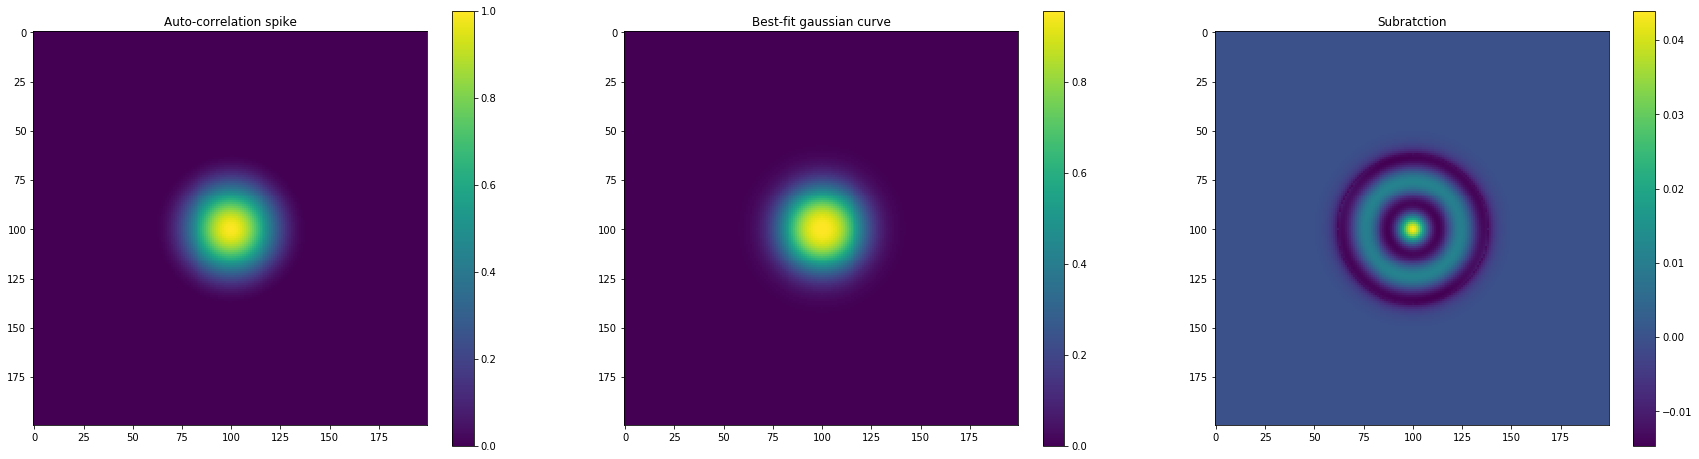

In [60]:
plt.figure(figsize=(30,8))

plt.subplot(1, 3, 1)
plt.title("Auto-correlation spike")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Best-fit gaussian curve")
plt.imshow(gauss1)
plt.colorbar()


plt.subplot(1, 3, 3)
plt.title("Subratction")
plt.imshow(diff1)
plt.colorbar()

# plt.savefig("images/curve_fit_subtraction")
plt.show()

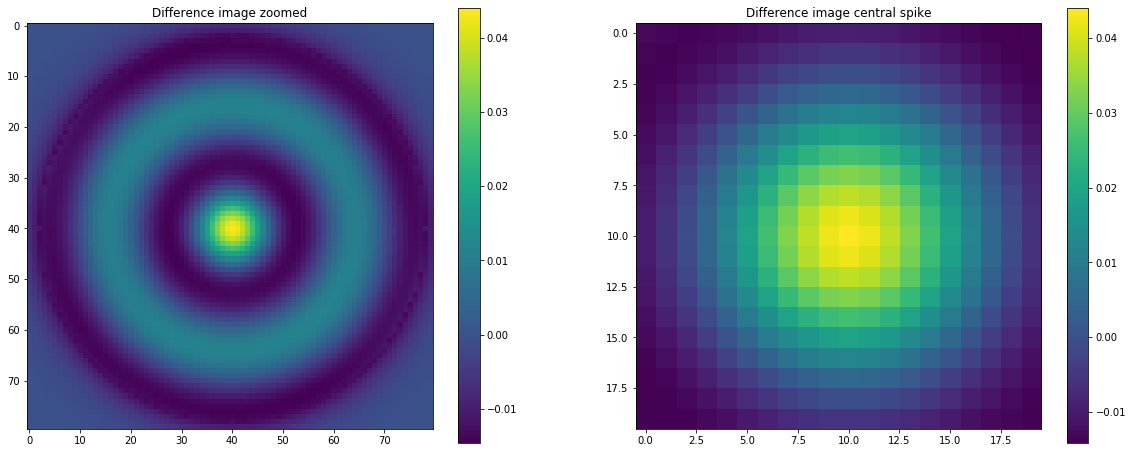

In [61]:
plt.figure(figsize=(20,8))
c2 = diff1.shape[0]//2
s3 = 40
s4 = 10

plt.subplot(1, 2, 1)
plt.title("Difference image zoomed")
plt.imshow(diff1[c2-s3:c2+s3, c2-s3:c2+s3])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Difference image central spike")
plt.imshow(diff1[c2-s4:c2+s4, c2-s4:c2+s4])
plt.colorbar()

# plt.savefig("images/diff_examine")
plt.show()

---

## Now format the output values

In [62]:
pixel_ratio = 0.1
amplitude_out = res1['x'][0]/np.max(data)
sigma_out = pixel_ratio*res1['x'][1]
power_out = res1['x'][2]

print("Amplitude: {}".format(amplitude_out))
print("Sigma: {}".format(sigma_out))
print("Power: {}".format(p))

fit_values = np.array([amplitude_out, sigma_out, power_out])
# np.save("fit_values.npy", fit_values)

Amplitude: 0.9560733115458723
Sigma: 1.5163002025409609
Power: 1.266396063431393


---

# Dan's method 

Something is going wrong and I dont know what

In [63]:
def model(theta, x, y):
    """ Here's our 2d gaussian model """
    amplitude, sigma, power = theta
    A = amplitude
    exponent = (x**2/(2*sigma**2) + y**2/(2*sigma**2))**power
    z = A * np.exp(-exponent)
    return z

def lnprior(theta):
    """ Here's where we define bounds for our model - the prior"""
    amplitude, sigma, power = theta
    return 0.
    if amplitude > 0. and sigma > 0. and power > 0.:
        return 0.
    return -np.inf

def lnlike(theta, x, y, z):
    """ Here's the log likelihood """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    z_model = model(theta, x, y)
    return lp + (-0.5 * np.sum((z - z_model) ** 2))

""" I alias the log likelihood to be negative, so i can use a minimizer on it"""
nll = lambda *args: -lnlike(*args)

In [68]:
xs = np.linspace(0, dim, num=dim, endpoint=False) - (dim/2)
X, Y = np.meshgrid(xs, xs)

start2 = [A0, sig0, p0]
nll(start2, X, Y, data)

70.63488312137144

In [74]:
res2

      fun: 0.2769587781937106
 hess_inv: array([[ 0.00596917, -0.05238462, -0.0113507 ],
       [-0.05238462,  0.61367739,  0.10958996],
       [-0.0113507 ,  0.10958996,  0.03542197]])
      jac: array([3.45706940e-06, 9.31322575e-08, 8.12113285e-07])
  message: 'Optimization terminated successfully.'
     nfev: 90
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([ 0.95607331, 15.16300199,  1.26639594])

In [71]:
res2 = minimize(nll, start2, args=(X, Y, data))
gauss2 = model(res2["x"], X, Y)
diff2 = data - gauss2
A2, sig2, p2 = res2["x"]

print("Error out: {}".format(res2["fun"]))
print("Iterations: {}".format(res2["nit"]))
print("Amplitude: {}".format(A))
print("Sigma: {}".format(sig))
print("Power: {}".format(p))
# print("Position: ({}, {})".format(x0, y0))

Error out: 0.2769587781937106
Iterations: 14
Amplitude: 0.9560732681738899
Sigma: 15.163002378828663
Power: 1.266396063431393


/Users/louis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


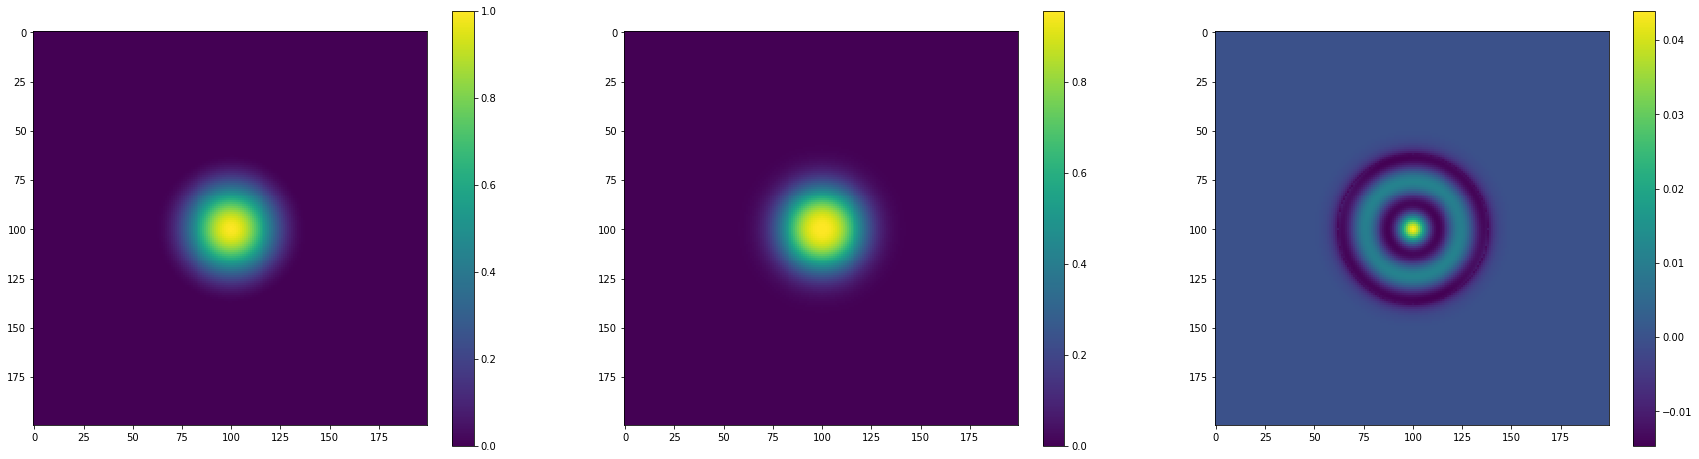

In [72]:
plt.figure(figsize=(30,8))

plt.subplot(1, 3, 1)
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(gauss2)
plt.colorbar()


plt.subplot(1, 3, 3)
plt.imshow(diff2)
plt.colorbar()

plt.show()